In [2]:
# imports
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools
from prophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import plotly.express as px
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima, ARIMA
import matplotlib.pyplot as plt
import holidays
import time
import datetime
pd.options.plotting.backend = 'plotly'

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sktime\utils\validation\series.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
def preprocessing_ARIMA(ts, ts_holiday, split=True, yearly_seasonality=True, steps_ahead=30):
    '''
    split: to split into train and test set
    '''
    print(f'Preprocessing timeseries data with {steps_ahead} steps ahead')
    ts = ts['sales']/1e6
    ts.index.freq = 'D'
    # yearly seasonality
    if yearly_seasonality:
        fouri_terms = FourierFeaturizer(365.25, 2)
        y_prime, df_fouri = fouri_terms.fit_transform(ts)
        df_fouri.index = y_prime.index
    # combine exog. variables
    df_exog = pd.concat([df_fouri, ts_holiday], axis=1)
    df_exog['holiday'] = df_exog['holiday'].fillna(False).astype('int')
    df_exog.dropna(inplace=True)
    if split:
        # split
        y_train = y_prime.iloc[:-steps_ahead]
        y_test = y_prime.iloc[-steps_ahead:]
        exog_train = df_exog.iloc[:-steps_ahead]
        exog_test = df_exog.iloc[-steps_ahead:]
        return {'y_train':y_train,
                'y_test':y_test,
                'exog_train':exog_train,
                'exog_test':exog_test}
    else:
        return {'y':y_prime, 'exog': df_exog}

def preprocessing_prophet(ts, ts_holiday, steps_ahead=30, split = True):
    fb_df = ts[['sales']]
    fb_df['sales'] = ts['sales']/1e6
    #fb_df['holiday'] = fb_df['holiday'].fillna(False).astype('bool')
    fb_df = fb_df.reset_index().rename({'date': 'ds', 'sales': 'y'}, axis=1)
    if split:
        fb_train = fb_df.iloc[:-steps_ahead]
        fb_test = fb_df.iloc[-steps_ahead:]
        return {'y_train':fb_train,
                'y_test':fb_test}
    else:
        return fb_df

def holidays_ts_prophet(promotion = True, holiday_neg=False):
    holiday = pd.DataFrame(holidays.Vietnam(years=[2018, 2019, 2020, 2021]).items()).rename({0:'date', 1:'holiday_neg'}, axis=1)
    # Add Tet promotion
    promo = pd.DataFrame(holiday[holiday.holiday_neg == 'Vietnamese New Year'].date - datetime.timedelta(days=1))
    promo['promotion'] = "1 days before Tet Holiday"
    # Add Black Friday
    promo = promo.append(
                pd.DataFrame({'date':[datetime.date(2020,11,27), 
                                      datetime.date(2019,11,29),
                                      datetime.date(2018,11,23)],
                              'promotion':["Black Friday","Black Friday","Black Friday"]}))
    # set to 1 if holiday affect sales negatively
    holiday_off = holiday.replace({
            'Vietnamese New Year.*': 1, 
             '.*day of Tet Holiday': 1,
             'International Labor Day': 1,
             '\D': np.NaN}, 
            regex=True).dropna()
    if promotion:
        promotions = pd.DataFrame({
                'holiday':'big_promotion',
                'ds':promo.date,
                'lower_window': -14, # 2 weeks before
                'upper_window': 0})
    else:
        promotions = None
    if holiday_neg:
        holiday_negative = pd.DataFrame({
                'holiday':'holiday_off',
                'ds':holiday_off.date,
                'lower_window': 0,
                'upper_window': 0})
    else:
        holiday_negative = None
    return pd.concat((promotions, holiday_negative))

def auto_arima_model(y_train, exog_train, diff_num):
    time_start = time.time()
    print('start auto arima...')
    # Fit model to the level to find common order
    arima_model = auto_arima(
        y=y_train,
        exogenous=exog_train,
        D=diff_num, 
        seasonal=True, m=7 # Weekly seasonality
    )
    time_stop = time.time()
    print(f'finished auto arima, model: {arima_model}, total time: {round(time_stop-time_start)} sec')
    return arima_model

def cross_validation_prophet(prophet_data, param_grid, steps_ahead = 30):
    cv_prophet_result = pd.DataFrame(columns=['params','mape','rmse'])
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    for params in all_params:
        # set up model
        prophet_model = Prophet(**params
                                ).add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10
                                ).add_seasonality(name='yearly', period=365.25, fourier_order=5, prior_scale=1)
        #m.add_regressor('holiday')
        prophet_model.fit(prophet_data['y_train'])
        # set up CV
        df_cv = cross_validation(prophet_model, initial=(str(prophet_data['y_train'].shape[0]-steps_ahead*2)+' days'), period='7 days', horizon='30 days', parallel="processes")
        # evaluate
        df_p = performance_metrics(df_cv)
        cv_prophet_result = cv_prophet_result.append({'params':params, 
                                            'mape'  :df_p['mape'].values[-1],
                                            'rmse'  :df_p['rmse'].values[-1]}, ignore_index=True)
    return cv_prophet_result

def cross_validation_result(data, model_name, model, rolls=4, horizon=30, prophet_params=None):
    '''
    '''
    cv_score = []
    for i in range(rolls):
        if model_name=='arima':
            model.fit(y=data['y'].iloc[:-(rolls-i)*horizon], 
                      X=data['exog'].iloc[:-(rolls-i)*horizon])
            y_hat = model.predict(n_periods=horizon, 
                                  exogenous=data['exog'].iloc[np.r_[-(rolls-i)*horizon:-(rolls-i-1)*horizon]])
            y_test = data['y'].iloc[np.r_[-(rolls-i)*horizon:-(rolls-i-1)*horizon]]
            mape_OOS = round(mean_absolute_percentage_error(y_test, y_hat), 3)
        elif model_name=='prophet':
            model = Prophet(**prophet_params
                           ).add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10
                           ).add_seasonality(name='yearly', period=365.25, fourier_order=5, prior_scale=1)
            model.fit(data.iloc[:-(rolls-i)*horizon,:])
            y_hat=model.predict(data.iloc[np.r_[-(rolls-i)*horizon:-(rolls-i-1)*horizon],:])['yhat']
            y_test = data['y'].iloc[np.r_[-(rolls-i)*horizon:-(rolls-i-1)*horizon]]
            mape_OOS = round(mean_absolute_percentage_error(y_test, y_hat), 3)
        cv_score.append(mape_OOS)
    return cv_score

In [4]:
def manual_holidays_gen(df_company):
    df_exog = pd.DataFrame(index=df_company.index)
    off_day_idx = [
        pd.date_range("2018-02-15", "2018-02-20"),  # Lunar New Year
        pd.date_range("2019-02-04", "2019-02-09"),  # Lunar New Year
        pd.date_range("2020-01-24", "2020-01-29"),  # Lunar New Year
        pd.date_range("2018-05-01", "2018-05-01"),  # Labor Day
        pd.date_range("2019-05-01", "2019-05-01"),  # Labor Day
        pd.date_range("2020-05-01", "2020-05-01"),  # Labor Day
    ]
    off_day_idx = pd.DatetimeIndex(np.unique(np.hstack(off_day_idx)))
    df_exog["off_day"] = False
    df_exog.loc[off_day_idx, "off_day"] = True

    promo_day_idx = [
        # Black Friday
        pd.date_range(end="2017-11-24", periods=14),
        pd.date_range(end="2018-11-23", periods=14),
        pd.date_range(end="2019-11-29", periods=14),
        pd.date_range(end="2020-11-27", periods=14),
        # End of year
        pd.date_range(end="2018-02-15", periods=15),
        pd.date_range(end="2019-02-04", periods=15),
        pd.date_range(end="2020-01-24", periods=15),
        pd.date_range(end="2021-01-31", periods=3),  # 2021 Tet is on 2021-02-12
        # Valentine
        pd.date_range(end="2018-02-14", periods=7),
        pd.date_range(end="2019-02-14", periods=7),
        pd.date_range(end="2020-02-14", periods=7),
        # International Women’s day
        pd.date_range(end="2018-03-08", periods=7),
        pd.date_range(end="2019-03-08", periods=7),
        pd.date_range(end="2020-03-08", periods=7),
        # Vietnam Reunification day
        pd.date_range(end="2018-04-30", periods=10),
        pd.date_range(end="2019-04-30", periods=10),
        pd.date_range(end="2020-04-30", periods=10),
        # End of school year
        pd.date_range(end="2018-05-27", periods=4),
        pd.date_range(end="2019-05-27", periods=4),
        pd.date_range(end="2020-05-27", periods=4),
        # New school year
        pd.date_range(end="2018-08-26", periods=3),
        pd.date_range(end="2019-08-26", periods=3),
        pd.date_range(end="2020-08-26", periods=3),
        # Vietnamese Women’s day
        pd.date_range(end="2018-10-20", periods=1),
        pd.date_range(end="2019-10-20", periods=1),
        pd.date_range(end="2020-10-20", periods=1),
    ]
    promo_day_idx = pd.DatetimeIndex(np.unique(np.hstack(promo_day_idx)))
    df_exog["promo_day"] = False
    df_exog.loc[promo_day_idx, "promo_day"] = True
    df_exog = df_exog.astype("int")
    return df_exog

In [5]:
df_store = pd.read_pickle("data/df_daily.pkl")
ts_holiday = pd.read_pickle('data/holiday.pkl')
df_company = df_store.groupby("date").sum()[["sales"]]
df_exog = manual_holidays_gen(df_company)

In [6]:
models_to_run = ['arima','prophet']
steps_ahead=7
prophet_holidays=holidays_ts_prophet(promotion=True, holiday_neg=True)
param_grid_prophet = {
    'changepoint_prior_scale': [0.01, 0.1, 1, 10],
    'changepoint_range': [0.8, 0.9],
    'holidays_prior_scale':[0.1, 1],
    'seasonality_mode': ['additive'],
    'holidays':[prophet_holidays],
    'daily_seasonality': [False],
    'weekly_seasonality': [False],
    'yearly_seasonality': [False],
}

C:\Users\Admin\AppData\Local\Temp\ipykernel_6912\3898026035.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  promo = promo.append(


In [6]:
df_store.head()

,date,store_id,sales,promo_count,store_level,store_group,store_format,store_segment,opening_date,status,store_area,number_of_staff,province,channel
0,2017-08-07,307222,1527650.0,1,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
1,2017-08-08,307222,0.0,0,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
2,2017-08-09,307222,26627420.0,14,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
3,2017-08-10,307222,10755720.0,9,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
4,2017-08-11,307222,10216950.0,10,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail


## ARIMA

In [13]:
model_name = 'arima'
best_model_group ={}
cv_pipe_result = {}
best_model = {}

In [14]:
all_stores_result_CV = pd.DataFrame(columns=['store_segment','store','mape'])
for store_segment in df_store.store_segment.unique():
    # get aggregated data for each store_segment
    df_store_segment = df_store[df_store.store_segment == store_segment].groupby('date').sum()
    # Cross-validation
    data = preprocessing_ARIMA(ts=df_store_segment, ts_holiday=ts_holiday, split=True, yearly_seasonality=True, steps_ahead=steps_ahead)
    arima_model = auto_arima_model(y_train=data['y_train'], exog_train=data['exog_train'], diff_num=1)
    # now get the data for cross-validatio and start the process
    data = preprocessing_ARIMA(ts=df_store_segment, ts_holiday=ts_holiday, split=False, yearly_seasonality=True, steps_ahead=steps_ahead) 
    cv_score = cross_validation_result(data=data, model_name=model_name, model=arima_model, rolls=4, horizon=steps_ahead)
    # save result
    cv_pipe_result[store_segment] = cv_score
    best_model_group[store_segment] = arima_model
    stores_result_CV=[]
    store_list=df_store[df_store['store_segment']==store_segment]['store_id'].unique()
    for store in store_list:  # print(store)
        print(f'processing stores {store}...')
        store_name = "store_" + str(store)
        # data
        df_data = df_store[df_store["store_id"] == store].set_index("date")[["sales"]]
        arima_data = preprocessing_ARIMA(ts=df_data, 
                                    ts_holiday=ts_holiday, 
                                    split=False, 
                                    yearly_seasonality=True, 
                                    steps_ahead=steps_ahead) 
        # fit model to each store
        cv_score = cross_validation_result(
            data=arima_data, model_name=model_name, model=best_model_group[store_segment], rolls=4, horizon=steps_ahead)
        # result
        stores_result_CV.append(np.mean(cv_score))
    all_stores_result_CV = pd.concat(
                                [all_stores_result_CV,
                                pd.DataFrame({'store_segment':store_segment,'store':store_list,'mape':stores_result_CV})]
                                
    )



Preprocessing timeseries data with 7 steps ahead
start auto arima...
finished auto arima, model:  ARIMA(2,0,4)(2,1,0)[7]          , total time: 258 sec
Preprocessing timeseries data with 7 steps ahead
processing stores 307222...
Preprocessing timeseries data with 7 steps ahead
processing stores 307244...
Preprocessing timeseries data with 7 steps ahead
processing stores 349920...
Preprocessing timeseries data with 7 steps ahead
processing stores 349924...
Preprocessing timeseries data with 7 steps ahead
processing stores 349958...
Preprocessing timeseries data with 7 steps ahead
processing stores 349972...
Preprocessing timeseries data with 7 steps ahead
processing stores 349980...
Preprocessing timeseries data with 7 steps ahead
processing stores 349998...
Preprocessing timeseries data with 7 steps ahead
processing stores 350018...
Preprocessing timeseries data with 7 steps ahead
processing stores 350040...
Preprocessing timeseries data with 7 steps ahead
processing stores 350060...
P

In [15]:
result_group_arima = all_stores_result_CV
print(best_model_group)
print(cv_pipe_result)

{'Mainstream': ARIMA(order=(2, 0, 4), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True, with_intercept=False), 'Mass': ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True), 'Flagship': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)}
{'Mainstream': [0.262, 0.185, 0.204, 0.142], 'Mass': [0.176, 0.129, 0.122, 0.08], 'Flagship': [0.279, 0.247, 0.216, 0.106]}


In [16]:
result_group_arima.mape.mean()

0.3630855263157895

## Prophet

In [17]:
model_name = 'prophet'
best_model_group ={}
cv_pipe_result = {}
best_model = {}

In [18]:
all_stores_result_CV = pd.DataFrame(columns=['store_segment','store','mape'])
for store_segment in df_store.store_segment.unique():
    # get aggregated data for each store_segment
    df_store_segment = df_store[df_store.store_segment == store_segment].groupby('date').sum()

    data = preprocessing_prophet(ts=df_store_segment, ts_holiday=prophet_holidays, steps_ahead=steps_ahead,split=True)
    cv_prophet_result = cross_validation_prophet(prophet_data=data, 
                                                    param_grid=param_grid_prophet,                                                       
                                                    steps_ahead = 30) # using cross validation for 30 days
    prophet_params = cv_prophet_result.sort_values('mape').iloc[0,0]
    # now get the data for cross-validatio and start the process
    data = preprocessing_prophet(ts=df_store_segment, ts_holiday=prophet_holidays, steps_ahead=steps_ahead,split=False)
    cv_score = cross_validation_result(data=data, model_name=model_name, model=None, rolls=4, horizon=steps_ahead, prophet_params=prophet_params)
    # save result
    cv_pipe_result[store_segment] = cv_score
    best_model_group[store_segment] = prophet_params
    stores_result_CV=[]
    store_list=df_store[df_store['store_segment']==store_segment]['store_id'].unique()
    for store in store_list:  # print(store)
        print(f'processing stores {store}...')
        store_name = "store_" + str(store)
        # data
        df_data= df_store[df_store["store_id"] == store].set_index("date")[["sales"]]
        prophet_store_data = preprocessing_prophet(
            ts=df_data, ts_holiday=prophet_holidays,
            steps_ahead=steps_ahead, split=False
        )

        # fit model to each store
        cv_score = cross_validation_result(data=prophet_store_data, 
                                        model_name=model_name, model=None, 
                                        rolls=4, horizon=steps_ahead, 
                                        prophet_params=best_model_group[store_segment])
        # result
        stores_result_CV.append(np.mean(cv_score))
    all_stores_result_CV = pd.concat(
                                [all_stores_result_CV,
                                pd.DataFrame({'store_segment':store_segment,'store':store_list,'mape':stores_result_CV})]
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_6672\3898026035.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb_df['sales'] = ts['sales']/1e6
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 5 forecasts with cutoffs between 2020-11-27 00:00:00 and 2020-12-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000024136F52430>
C:\Users\Admin\AppData\Local\Temp\ipykernel_6672\3898026035.py:107: Fut

processing stores 307222...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 307244...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349920...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349924...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349958...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349972...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349980...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349998...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350018...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350040...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350060...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 480733...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 566792...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 307248...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 320264...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349952...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349962...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349978...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350016...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350026...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350028...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350046...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350054...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350056...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 354468...


C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated 

processing stores 387240...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 412585...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 441997...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 452387...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 461349...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 464495...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 471477...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 476061...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 536898...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 536902...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 328165...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 528854...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 566790...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

In [20]:
result_group_prophet = all_stores_result_CV
#print(best_model_group)
print(cv_pipe_result)

{'Mainstream': [0.183, 0.268, 0.199, 0.11], 'Mass': [0.158, 0.213, 0.202, 0.184], 'Flagship': [0.36, 0.252, 0.289, 0.15]}


In [25]:
print(result_group_arima.groupby("store_segment")['mape'].mean())

store_segment
Flagship      0.334083
Mainstream    0.343538
Mass          0.378591
Name: mape, dtype: float64


In [26]:
print(result_group_prophet.groupby("store_segment")['mape'].mean())

store_segment
Flagship      0.299250
Mainstream    0.301115
Mass          0.348955
Name: mape, dtype: float64


In [46]:
result_group_arima.to_pickle("results/grouping/result_group_location_arima.pkl")
result_group_prophet.to_pickle("results/grouping/result_group_location_prophet.pkl")

## Group by error rate

In [9]:
score_ARIMA = pd.read_pickle("results/f8/ARIMA_7.pkl").set_index("store")
score_PROPHET = pd.read_pickle("results/f8/PROPHET_7.pkl").set_index("store")
#score_SNAIVE = pd.read_pickle("results/f8/SNAIVE_7.pkl").set_index("store")

score_ALL = score_ARIMA.join(score_PROPHET)
score_ALL.head()

,mae_ARIMA,rmse_ARIMA,mape_ARIMA,mase_ARIMA,fc_ARIMA,mae_PROPHET,rmse_PROPHET,mape_PROPHET,mase_PROPHET,fc_PROPHET
store,,,,,,,,,,
store_307222,7.91225,9.09375,0.28100,0.80050,"[34.66248403616754, 28.328400365946095, 22.329...",7.07675,8.79800,0.23400,0.71600,ds trend yhat_lower yhat_uppe...
store_307244,6.67450,7.74325,0.34550,0.85575,"[13.835429749967066, 13.977082334680194, 13.18...",6.48750,8.06575,0.30900,0.83200,ds trend yhat_lower yhat_uppe...
store_307248,7.31325,8.78150,0.36300,1.06350,"[20.370068633697326, 15.048735970050245, 12.96...",5.43775,6.67150,0.23900,0.79100,ds trend yhat_lower yhat_uppe...
store_320264,6.46950,7.86525,0.39100,0.95450,"[23.824847833579213, 15.790110510681625, 9.840...",4.64275,7.18550,0.26875,0.68500,ds trend yhat_lower yhat_upper...
store_328165,25.69050,34.02775,0.33325,1.17175,"[88.15915634559391, 66.91400890470602, 47.5110...",27.24225,36.93400,0.35700,1.24275,ds trend yhat_lower yhat_uppe...


In [10]:
metric_features = ['mape_ARIMA','mape_PROPHET']

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

KMeans(init='random', random_state=1)

In [15]:
inertia = []
for n_clus in range(1,7):  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(score_ALL[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

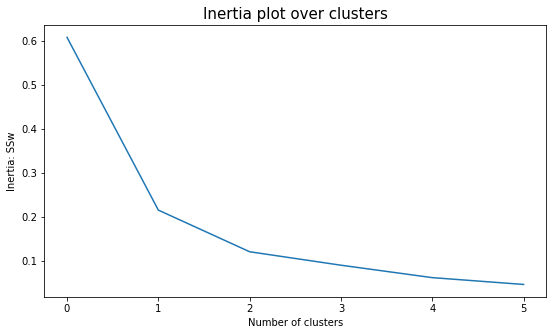

In [19]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [28]:
# from elbow plot, let decide 3 clusters
kmclust = KMeans(n_clusters=3, init='random', n_init=10, random_state=1)
# the fit method
kmclust.fit(score_ALL[metric_features])
clusters = pd.Series(kmclust.predict(score_ALL[metric_features]), name="cluster", index=score_ALL.index)

In [55]:
score_ALL_final = pd.concat([score_ALL,clusters],axis = 1)

In [56]:
score_ALL_final.groupby('cluster').mean()

,mae_ARIMA,rmse_ARIMA,mape_ARIMA,mase_ARIMA,mae_PROPHET,rmse_PROPHET,mape_PROPHET,mase_PROPHET
cluster,,,,,,,,
0,8.535510,10.646250,0.334500,1.054990,7.795788,10.019990,0.285433,0.940990
1,3.422083,4.237417,0.547583,0.840167,3.728250,4.495583,0.593083,0.920917
2,5.746333,7.190389,0.446694,1.023806,5.837361,7.009167,0.406417,0.992361


In [57]:
score_ALL_final.value_counts('cluster')

cluster
0    26
2     9
1     3
dtype: int64

### Forecast with cluster result

In [58]:
score_ALL_final=score_ALL_final.reset_index()
score_ALL_final['store_id']=score_ALL_final.reset_index()['store'].map(lambda x: x.split("_")[1]).astype(int)

In [63]:
model_name = 'prophet'
best_model_group ={}
cv_pipe_result = {}
best_model = {}
df_store = pd.read_pickle("data/df_daily.pkl")
df_store=pd.merge(df_store, score_ALL_final[['cluster','store_id']], on=['store_id'])

In [64]:
all_stores_result_CV = pd.DataFrame(columns=['cluster','store','mape'])
for cluster in df_store.cluster.unique():
    # get aggregated data for each cluster
    df_cluster = df_store[df_store.cluster == cluster].groupby('date').sum()

    data = preprocessing_prophet(ts=df_cluster, ts_holiday=prophet_holidays, steps_ahead=steps_ahead,split=True)
    cv_prophet_result = cross_validation_prophet(prophet_data=data, 
                                                    param_grid=param_grid_prophet,                                                       
                                                    steps_ahead = 30) # using cross validation for 30 days
    prophet_params = cv_prophet_result.sort_values('mape').iloc[0,0]
    # now get the data for cross-validatio and start the process
    data = preprocessing_prophet(ts=df_cluster, ts_holiday=prophet_holidays, steps_ahead=steps_ahead,split=False)
    cv_score = cross_validation_result(data=data, model_name=model_name, model=None, rolls=4, horizon=steps_ahead, prophet_params=prophet_params)
    # save result
    cv_pipe_result[cluster] = cv_score
    best_model_group[cluster] = prophet_params
    stores_result_CV=[]
    store_list=df_store[df_store['cluster']==cluster]['store_id'].unique()
    for store in store_list:  # print(store)
        print(f'processing stores {store}...')
        store_name = "store_" + str(store)
        # data
        df_data= df_store[df_store["store_id"] == store].set_index("date")[["sales"]]
        prophet_store_data = preprocessing_prophet(
            ts=df_data, ts_holiday=prophet_holidays,
            steps_ahead=steps_ahead, split=False
        )

        # fit model to each store
        cv_score = cross_validation_result(data=prophet_store_data, 
                                        model_name=model_name, model=None, 
                                        rolls=4, horizon=steps_ahead, 
                                        prophet_params=best_model_group[cluster])
        # result
        stores_result_CV.append(np.mean(cv_score))
    all_stores_result_CV = pd.concat(
                                [all_stores_result_CV,
                                pd.DataFrame({'cluster':cluster,'store':store_list,'mape':stores_result_CV})]
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_6912\3898026035.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fb_df['sales'] = ts['sales']/1e6
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 5 forecasts with cutoffs between 2020-11-27 00:00:00 and 2020-12-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C95A1B4370>
C:\Users\Admin\AppData\Local\Temp\ipykernel_6912\3898026035.py:107: Fut

processing stores 307222...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 307244...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 307248...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 320264...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 328165...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349920...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349924...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349952...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349958...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349962...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349972...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349980...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349998...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350016...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350018...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350026...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350028...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350046...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350054...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350060...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 441997...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 452387...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 471477...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 480733...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 528854...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 536902...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 349978...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350040...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 350056...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 387240...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 412585...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 461349...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 464495...


C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated 

processing stores 536898...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 566790...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 354468...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 476061...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

processing stores 566792...


INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
C:\Users\Admin\anaconda3\envs\DataMining_Lab\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The fram

In [66]:
result_group_cluster_prophet = all_stores_result_CV
#print(best_model_group)
print(cv_pipe_result)

{0: [0.182, 0.232, 0.183, 0.133], 2: [0.291, 0.253, 0.297, 0.234], 1: [0.467, 0.175, 0.285, 0.496]}


In [68]:
result_group_cluster_prophet.mape.mean()

0.32276973684210525

In [69]:
result_group_cluster_prophet.to_pickle("results/grouping/result_group_cluster_prophet.pkl")